<a href="https://colab.research.google.com/github/tonyw54/GeorgeBrown/blob/main/Tony_Waterman_Misogyny_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Course: Deep Learning I CRN-18160-202401

Group Members: Tony Waterman (101199518)

Date: September 27, 2024

We are using two datasets.
1. https://aclanthology.org/2021.eacl-main.114/
2. https://huggingface.co/datasets/mila-ai4h/biasly-data

Early attempts to train BERT models with this data did not work very well. These early attempts can be seen at https://github.com/tonyw54/GeorgeBrown/blob/main/BERT_Misogyny_Classifier.ipynb and https://github.com/tonyw54/GeorgeBrown/blob/main/Misogyny_classifier_2.ipynb.

These open source BERT models are subject to a large amount of gender-based bias (see https://huggingface.co/google-bert/bert-base-uncased#limitations-and-bias), which made these models unsuitable for a misogyny classifier. Instead, we used a BERT for tokenization (which worked well), but the neural network in this project is a completely new PyTorch RNNClassifier, trained on this model.

* Special thanks to Brooklyn Sheppard (brooklyn.sheppard1@ucalgary.ca) of the University of Calgary for allowing me to use her curated misogyny  dataset at https://huggingface.co/datasets/mila-ai4h/biasly-data.

In [3]:
# Download and unzip the first dataset
!wget https://aclanthology.org/attachments/2021.eacl-main.114.Dataset.zip
!unzip 2021.eacl-main.114.Dataset.zip

--2024-09-22 20:49:03--  https://aclanthology.org/attachments/2021.eacl-main.114.Dataset.zip
Resolving aclanthology.org (aclanthology.org)... 174.138.37.75
Connecting to aclanthology.org (aclanthology.org)|174.138.37.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2173869 (2.1M) [application/zip]
Saving to: ‘2021.eacl-main.114.Dataset.zip’

2021.eacl-main.114. 100%[===================>]   2.07M  1.39MB/s    in 1.5s    

2024-09-22 20:49:06 (1.39 MB/s) - ‘2021.eacl-main.114.Dataset.zip’ saved [2173869/2173869]

Archive:  2021.eacl-main.114.Dataset.zip
   creating: data/
  inflating: data/final_labels.csv   
  inflating: __MACOSX/data/._final_labels.csv  
  inflating: data/original_labels.csv  
  inflating: __MACOSX/data/._original_labels.csv  


In [4]:
# We will use PyTorch datasets in this project. These worked well.
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


This project only works on colab. The userdata class is meant to allow the HF_TOKEN (for Huggging Face) to import parquet files.

In [5]:
import pandas as pd
import numpy as np
import torch
import requests
import io
from google.colab import userdata
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
from datasets import Dataset, load_dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt

The first dataset has a field named level_1, which has values of "Misogynistic"  and "Nonmisogynistic". This field needs to be encoded. The encoding needs to match the second  dataset.  We use this field to create a new float field called is_misogynistic, then drop the level_1 field. The only fields we needed from this dataset (for this project) were "body", which contains the statement to be classified, and level_1, which was converted into the is_misogynistic field.

In [6]:
data = pd.read_csv("data/final_labels.csv")
selected_data = data[['body', 'level_1']]
selected_data['is_misogynistic'] = selected_data['level_1'].map({'Nonmisogynistic': 0.0, 'Misogynistic': 1.0})
selected_data = selected_data.drop('level_1', axis=1)

<ipython-input-6-f6cbab00c889>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['is_misogynistic'] = selected_data['level_1'].map({'Nonmisogynistic': 0.0, 'Misogynistic': 1.0})


The second dataset is from https://huggingface.co/datasets/mila-ai4h/biasly-data. This Hugging Face hosted dataset was curated by Brooklyn Sheppard at the University of Calgary, who assisted me in downloading the dataset.

In [7]:
url = 'https://huggingface.co/datasets/mila-ai4h/biasly-data/resolve/refs%2Fconvert%2Fparquet/biasly-data/train/0000.parquet'

# Get the token from Colab secrets
token = userdata.get('HF_TOKEN')
headers = {'Authorization': f'Bearer {token}'}

response = requests.get(url, headers=headers)
response.raise_for_status()

data2 = pd.read_parquet(io.BytesIO(response.content), engine='pyarrow')

In [8]:
selected_data2 = data2[['datapoint', 'is_misogynistic']]
selected_data2 = selected_data2.rename(columns={'datapoint': 'body'})
selected_data2['is_misogynistic'] = selected_data2['is_misogynistic'].map({'No': 0.0, 'Yes': 1.0})

Convert the two data sets into simple pandas lists. This drops all the PyTorch and Hugging Face extra stuff.

Also drop all rows where the is_misogynistic field is Nan. I could not decide whether these records are or are not misogynistic since I do not have the linguistic or gender studies expertise to do so. Instead I just deleted these records.

In [9]:
first_sentences = selected_data['body'].tolist()
first_labels = selected_data['is_misogynistic'].tolist()
df1 = pd.DataFrame({'body': first_sentences, 'is_misogynistic': first_labels})

second_sentences = selected_data2['body'].tolist()
second_labels = selected_data2['is_misogynistic'].tolist()
df2 = pd.DataFrame({'body': second_sentences, 'is_misogynistic': second_labels})

combined_data = pd.concat([df1, df2], ignore_index=True)
combined_data = combined_data.dropna(subset=['is_misogynistic'])

Display the dataset in a word cloud. As can be seen, this is a dataset full of bad things to say about women.

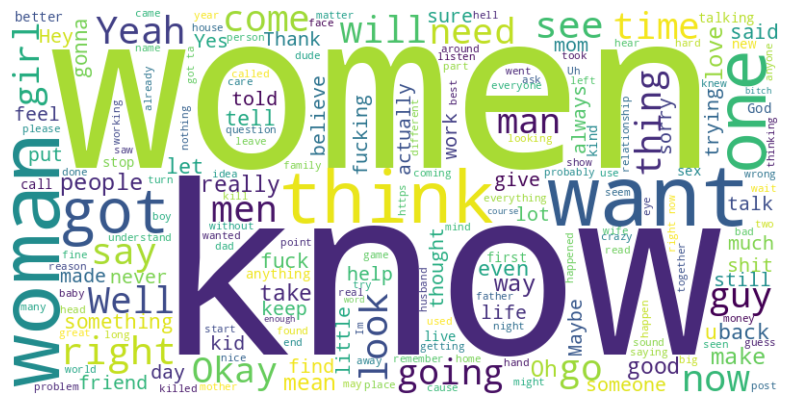

In [10]:
text = " ".join(combined_data["body"].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We tokenize the sentences using the bert-base-uncased model for tokenization. Any other tokenizer could have been used, but BERT works fine for turning words into numbers. We are generating our own RNNClassifier. Previous attempts found that the BERT models were actually full of sexism and racism. These models were pretrained on a huge, unsupervised corpus of text, so this is expected. Gender and race prejudice are common, so the unsupervised model picks up these biases.

In [11]:
sentences = combined_data["body"].astype(str).fillna("").tolist()
labels = combined_data["is_misogynistic"]

# Using BERT for tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode sentences and pad/truncate them
max_length = 50
encodings = tokenizer(sentences, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Split data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(encodings['input_ids'], labels, test_size=0.2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Now we define our PyTorch dataset. It is a simple Dataset with our sentences and labels. This is a simple Dataset so there is not much more to say about the definition.

In [12]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences # torch.Tensor
        self.labels = labels # pandas.core.series.Series

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels.iloc[idx]
        return {'sentence': sentence, 'label': label}

Our DataLoader uses our CustomDataset to format the statements and labels so the RNNClassifier neural network can train on this data.

In [13]:
# Create DataLoader
train_dataset = CustomDataset(train_sentences, train_labels)
val_dataset = CustomDataset(val_sentences, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

I am manually creating an RNNClassifier. Not because I like to do things the hard way, but because existing Bert models are known to be biased against race and gender. In early attempts to train these BERT models, I found the results were quite poor. Let's see if we can create a new model without the Bert sexism.

Setting LSTM to 10 layers, dropout 0.2, hidden_dim is 512

In [14]:
# Model parameters
vocab_size = len(tokenizer.vocab)
embedding_dim = 128
hidden_dim = 512
output_dim = 1  # Binary classification (0 or 1)

The classifier is, at this point, our untrained neural network.

In [15]:
class RNNClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, vocab_size):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=10, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hn, cn) = self.lstm(embedded)
        final_output = hn[-1]
        out = self.fc(final_output)
        return self.sigmoid(out)

We create an instance of the classifier, using binary cross-entropy, since we only have two possible outputs (is or is not misogynistic) from the data. I also tried to tweak the l1 and l2 lambda values. The below values seem to work OK.

In [16]:
model = RNNClassifier(embedding_dim, hidden_dim, output_dim, vocab_size)
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification, since it seems to work well
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Using Adam. Learning rate is difficult to adjust

l1_lambda = 0.001
l2_lambda = 0.001

First we create the arrays that will collect data about the training so we can display it in chart form later.

In [17]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

The binary_accuracy function is used to convert the percentage value from the model to either True or False.

In [18]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    # Squeeze labels to match the shape of rounded_preds
    correct = (rounded_preds == y.squeeze(1)).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

Now train the thing and see how well it does. This training process takes about 2 hours on a colab GPU, which seems to be the price of creating a neural network from scratch. We run through the data set 10 times.

In [19]:
for epoch in range(5):  # More than 5 epochs leads to over fitting
    model.train()
    train_epoch_loss = 0
    train_epoch_acc = 0
    for batch in train_loader:
        optimizer.zero_grad()
        sentences = batch['sentence']
        # Ensure labels are floats and within the range [0, 1] and have the correct shape.
        labels = batch['label'].float().unsqueeze(1)
        outputs = model(sentences)
        loss = criterion(outputs, labels)
        # Squeeze outputs to match the expected shape for binary_accuracy
        acc = binary_accuracy(outputs.squeeze(1), labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_epoch_acc += acc.item()
    train_loss = train_epoch_loss / len(train_loader)
    train_acc = train_epoch_acc / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_epoch_loss = 0
    val_epoch_acc = 0
    with torch.no_grad():
        for batch in val_loader:
            sentences = batch['sentence']
            # Ensure labels are floats and within the range [0, 1] and have the correct shape.
            labels = batch['label'].float().unsqueeze(1)
            outputs = model(sentences)
            loss = criterion(outputs, labels)
            # Squeeze outputs to match the expected shape for binary_accuracy
            acc = binary_accuracy(outputs.squeeze(1), labels)
            val_epoch_loss += loss.item()
            val_epoch_acc += acc.item()
    val_loss = val_epoch_loss / len(val_loader)
    val_acc = val_epoch_acc / len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch: {epoch+1}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Train Loss: {train_loss:.4f},  Validation Loss: {val_loss:.4f}")

Epoch: 1, Train Accuracy: 0.8273, Validation Accuracy: 0.8226, Train Loss: 0.4419,  Validation Loss: 0.4132
Epoch: 2, Train Accuracy: 0.8282, Validation Accuracy: 0.8226, Train Loss: 0.3945,  Validation Loss: 0.4103
Epoch: 3, Train Accuracy: 0.8290, Validation Accuracy: 0.8266, Train Loss: 0.3793,  Validation Loss: 0.3816
Epoch: 4, Train Accuracy: 0.8296, Validation Accuracy: 0.8207, Train Loss: 0.3662,  Validation Loss: 0.3808
Epoch: 5, Train Accuracy: 0.8301, Validation Accuracy: 0.8203, Train Loss: 0.3550,  Validation Loss: 0.3713


Now let's see how well the model works. It seems to be better than the earlier BERT attempts. The training and validation loss are roughly similar. Training and validation accuracy are starting to diverge somewhat. This suggests we might be into over fitting. It seems like we should only run the training for 5 epochs.

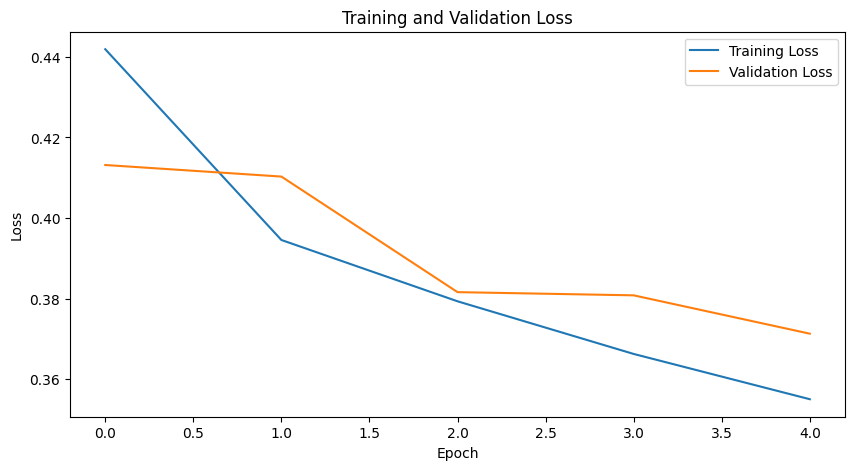

In [28]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

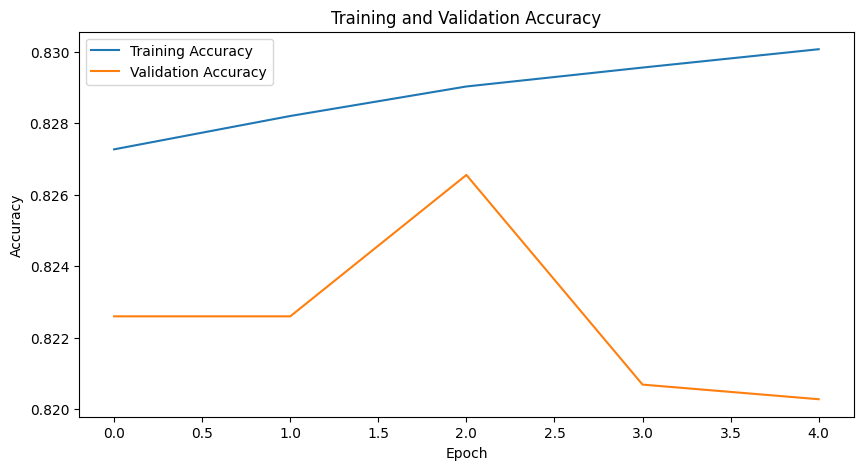

In [29]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Misogyny is tough to classify. The validation accuracy is still pretty good.

Validation Accuracy: 82.05%


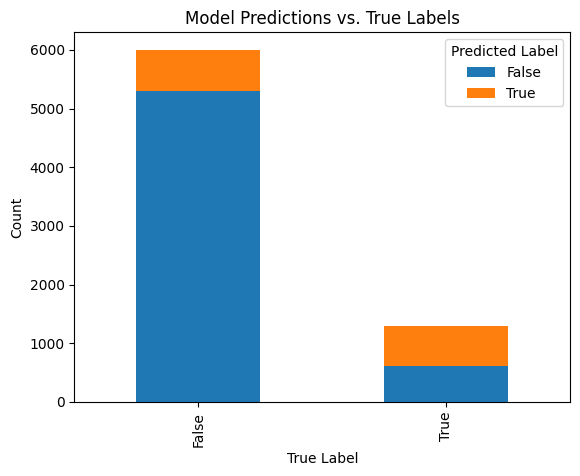

In [30]:
model.eval()
correct = 0
total = 0
all_val_predictions = []
all_val_labels = []

with torch.no_grad():
    for batch in val_loader:
        sentences = batch['sentence']
        labels = batch['label'].float()

        outputs = model(sentences).squeeze()
        predicted = (outputs > 0.5).float()  # Use 0.5 threshold for binary classification

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_val_predictions.extend(predicted.tolist())
        all_val_labels.extend(labels.tolist())

accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Convert predictions and labels to boolean values
predicted_labels_bool = [bool(pred) for pred in all_val_predictions]
true_labels_bool = [bool(label) for label in all_val_labels]

# Create a DataFrame for visualization
results_df = pd.DataFrame({'True Label': true_labels_bool, 'Predicted Label': predicted_labels_bool})

# Display the data in a chart (using a bar chart for example)
results_df['True Label'] = results_df['True Label'].astype(str)
results_df['Predicted Label'] = results_df['Predicted Label'].astype(str)

# Group by true and predicted labels and count occurrences
counts = results_df.groupby(['True Label', 'Predicted Label']).size().unstack()

# Plot the counts using a bar chart
counts.plot(kind='bar', stacked=True)
plt.xlabel('True')
plt.ylabel('Count')
plt.title('Model Predictions vs. True Labels')
plt.legend(title='Predicted')
plt.show()


In [31]:
def predict_sentence(sentence):
    test_encodings = tokenizer(sentence, padding=True, truncation=True, max_length=50, return_tensors='pt')
    with torch.no_grad():
        outputs = model(test_encodings['input_ids']).squeeze()
        predicted = (outputs > 0.5).float()
    return bool(predicted.item())

In [32]:
predict_sentence("It's math, dear. Don't worry your pretty little head about it.")

True

In [34]:
predict_sentence("Men tend to be mean to women.")

False

In [35]:
predict_sentence("Roses are red, violets are blue.")

False

In [36]:
predict_sentence("Women and their gossiping... am I right?")

True

In [38]:
predict_sentence("I can't stand all these gold diggers parked beside the mine shaft.")

False